In [21]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# Проверяем доступность GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используемое устройство: {device}')

# Фиксируем seed для воспроизводимости результатов
torch.manual_seed(42)
np.random.seed(42)


Используемое устройство: cuda


In [22]:
# Гиперпараметры
BATCH_SIZE = 64
LEARNING_RATE_G = 0.0001
LEARNING_RATE_D = 0.0004
BETA1 = 0.0  # для Adam оптимизатора
BETA2 = 0.9  # для Adam оптимизатора
NUM_EPOCHS = 50
LATENT_DIM = 128  # размерность латентного пространства
IMAGE_SIZE = 28
CHANNELS = 1

# Создание директории для сохранения результатов
os.makedirs('generated_images', exist_ok=True)
os.makedirs('models', exist_ok=True)

print(f"Гиперпараметры:")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Latent Dimension: {LATENT_DIM}")


Гиперпараметры:
Batch Size: 64
Learning Rate: 0.0002
Epochs: 50
Latent Dimension: 128


Количество батчей в тренировочном наборе: 938
Общее количество изображений: 60000


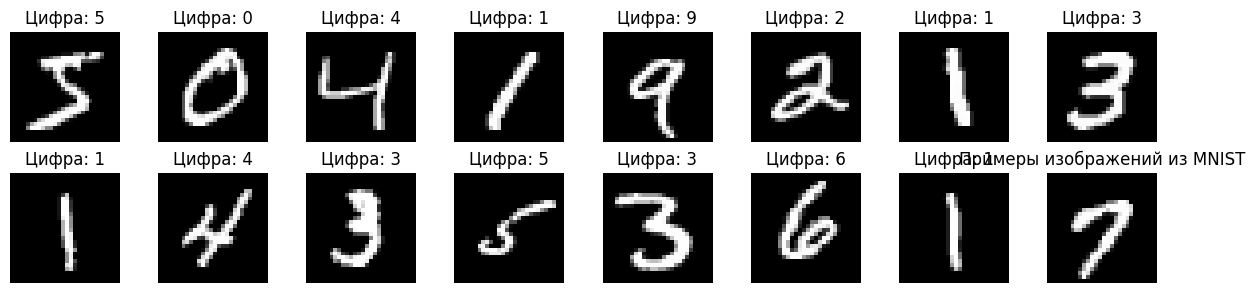

In [23]:
# Загрузка и предобработка данных MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # нормализация в диапазон [-1, 1]
])

# Загружаем датасет MNIST
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

print(f"Количество батчей в тренировочном наборе: {len(train_loader)}")
print(f"Общее количество изображений: {len(train_dataset)}")

# Визуализируем несколько примеров из датасета
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(16):
    img, label = train_dataset[i]
    axes[i//8, i%8].imshow(img.squeeze(), cmap='gray')
    axes[i//8, i%8].set_title(f'Цифра: {label}')
    axes[i//8, i%8].axis('off')
plt.tight_layout()
plt.title('Примеры изображений из MNIST')
plt.show()


In [24]:
# Определение архитектуры генератора
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_shape=(1, 28, 28)):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()  # выход в диапазоне [-1, 1]
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Создаем генератор
generator = Generator(LATENT_DIM, (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)).to(device)
print("Архитектура генератора:")
print(generator)


Архитектура генератора:
Generator(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)


In [25]:
# Определение архитектуры дискриминатора
class Discriminator(nn.Module):
    def __init__(self, img_shape=(1, 28, 28)):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.6),  # увеличиваем с 0.4 до 0.6
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.6),  # увеличиваем с 0.4 до 0.6
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Создаем дискриминатор
discriminator = Discriminator((CHANNELS, IMAGE_SIZE, IMAGE_SIZE)).to(device)
print("Архитектура дискриминатора:")
print(discriminator)


Архитектура дискриминатора:
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [26]:
# Функция потерь и оптимизаторы
adversarial_loss = nn.BCELoss()

# Оптимизаторы для генератора и дискриминатора
optimizer_G = optim.Adam(generator.parameters(), lr=0.0003, betas=(BETA1, 0.999))  # усиливаем генератор
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00005, betas=(BETA1, 0.999))  # ослабляем дискриминатор

print("Настройка завершена!")
print(f"Функция потерь: {adversarial_loss}")
print(f"Оптимизатор генератора: Adam (lr={LEARNING_RATE}, beta1={BETA1})")
print(f"Оптимизатор дискриминатора: Adam (lr={LEARNING_RATE}, beta1={BETA1})")


Настройка завершена!
Функция потерь: BCELoss()
Оптимизатор генератора: Adam (lr=0.0002, beta1=0.0)
Оптимизатор дискриминатора: Adam (lr=0.0002, beta1=0.0)


In [27]:
# Вспомогательные функции для визуализации и сохранения

def save_generated_images(generator, epoch, num_images=64):
    """Генерация и сохранение изображений"""
    generator.eval()
    with torch.no_grad():
        # Генерируем случайный шум
        z = torch.randn(num_images, LATENT_DIM).to(device)
        # Генерируем изображения
        generated_imgs = generator(z)
        
        # Преобразуем для визуализации
        generated_imgs = generated_imgs.cpu().detach()
        
        # Создаем сетку изображений
        fig, axes = plt.subplots(8, 8, figsize=(10, 10))
        for i in range(num_images):
            img = generated_imgs[i].squeeze()
            axes[i//8, i%8].imshow(img, cmap='gray')
            axes[i//8, i%8].axis('off')
        
        plt.suptitle(f'Сгенерированные изображения - Эпоха {epoch}')
        plt.tight_layout()
        plt.savefig(f'generated_images/epoch_{epoch:03d}.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    generator.train()

def plot_losses(g_losses, d_losses):
    """Построение графиков потерь"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(g_losses, label='Потери генератора', color='blue')
    plt.plot(d_losses, label='Потери дискриминатора', color='red')
    plt.xlabel('Итерация')
    plt.ylabel('Потери')
    plt.title('Потери во время обучения')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    # Скользящее среднее для сглаживания
    window = 50
    if len(g_losses) > window:
        g_smooth = np.convolve(g_losses, np.ones(window)/window, mode='valid')
        d_smooth = np.convolve(d_losses, np.ones(window)/window, mode='valid')
        plt.plot(g_smooth, label='Потери генератора (сгл.)', color='blue')
        plt.plot(d_smooth, label='Потери дискриминатора (сгл.)', color='red')
        plt.xlabel('Итерация')
        plt.ylabel('Потери (сглаженные)')
        plt.title('Сглаженные потери')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

print("Вспомогательные функции определены!")


Вспомогательные функции определены!


Сгенерированные изображения до обучения:


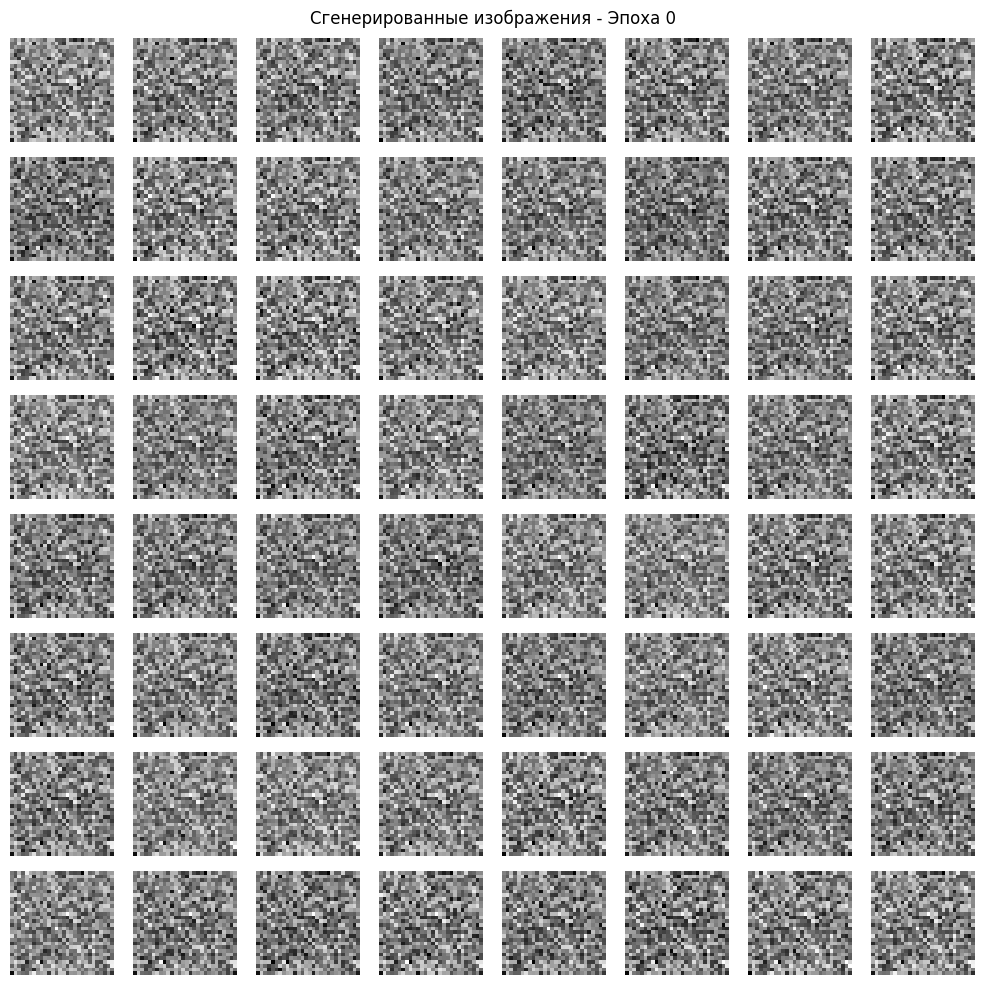

In [28]:
# Процесс обучения GAN
def train_gan():
    G_losses = []
    D_losses = []
    
    print("Начинаем обучение GAN...")
    
    for epoch in range(NUM_EPOCHS):
        epoch_g_loss = 0
        epoch_d_loss = 0
        
        # Прогресс-бар для текущей эпохи
        pbar = tqdm(train_loader, desc=f'Эпоха {epoch+1}/{NUM_EPOCHS}')
        
        for i, (real_imgs, _) in enumerate(pbar):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            # Добавляем шум к реальным изображениям - ослабляем дискриминатор
            real_imgs += 0.05 * torch.randn_like(real_imgs)
            real_imgs = torch.clamp(real_imgs, -1, 1)  # ограничиваем диапазон
            
            # Метки для настоящих и поддельных изображений
            real_labels = torch.ones(batch_size, 1).to(device) * 0.9
            fake_labels = torch.zeros(batch_size, 1).to(device) + 0.1
            
            # ---------------------
            # Обучение дискриминатора
            # ---------------------
            if i % 2 == 0:  # обучаем дискриминатор реже - ослабляем его
                optimizer_D.zero_grad()
                
                # Потери на настоящих изображениях
                real_output = discriminator(real_imgs)
                real_loss = adversarial_loss(real_output, real_labels)
                
                # Генерация поддельных изображений
                z = torch.randn(batch_size, LATENT_DIM).to(device)
                fake_imgs = generator(z)
                
                # Потери на поддельных изображениях
                fake_output = discriminator(fake_imgs.detach())
                fake_loss = adversarial_loss(fake_output, fake_labels)
                
                # Общие потери дискриминатора
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                optimizer_D.step()
            else:
                # Когда не обучаем дискриминатор, всё равно генерируем fake_imgs для генератора
                z = torch.randn(batch_size, LATENT_DIM).to(device)
                fake_imgs = generator(z)
                d_loss = torch.tensor(0.0)  # фиктивное значение для статистики
                
            # ---------------------
            # Обучение генератора
            # ---------------------
            optimizer_G.zero_grad()
            
            # Генератор пытается обмануть дискриминатор
            fake_output = discriminator(fake_imgs)
            g_loss = adversarial_loss(fake_output, real_labels)  # хотим, чтобы fake_output было близко к 1
            
            g_loss.backward()
            optimizer_G.step()

            if i % 3 == 0:  # каждый третий шаг - дополнительное обучение генератора
                optimizer_G.zero_grad()
                z_extra = torch.randn(batch_size, LATENT_DIM).to(device)
                fake_imgs_extra = generator(z_extra)
                fake_output_extra = discriminator(fake_imgs_extra)
                g_loss_extra = adversarial_loss(fake_output_extra, real_labels)
                g_loss_extra.backward()
                optimizer_G.step()
                g_loss = (g_loss + g_loss_extra) / 2  # усредняем для статистики
            
            # Сохраняем потери для статистики
            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            
            # Обновляем прогресс-бар
            pbar.set_postfix({
                'D_loss': f'{d_loss.item():.4f}',
                'G_loss': f'{g_loss.item():.4f}'
            })
        
        # Средние потери за эпоху
        avg_g_loss = epoch_g_loss / len(train_loader)
        avg_d_loss = epoch_d_loss / len(train_loader)
        
        print(f'Эпоха [{epoch+1}/{NUM_EPOCHS}] - D_loss: {avg_d_loss:.4f}, G_loss: {avg_g_loss:.4f}')
        
        # Сохраняем сгенерированные изображения каждые 10 эпох
        if (epoch + 1) % 10 == 0:
            save_generated_images(generator, epoch + 1)
        
        # Сохраняем модели каждые 25 эпох
        if (epoch + 1) % 25 == 0:
            torch.save(generator.state_dict(), f'models/generator_epoch_{epoch+1}.pth')
            torch.save(discriminator.state_dict(), f'models/discriminator_epoch_{epoch+1}.pth')
    
    return G_losses, D_losses

# Генерируем начальные изображения (до обучения)
print("Сгенерированные изображения до обучения:")
save_generated_images(generator, 0)


Начинаем обучение GAN...


Эпоха 1/50: 100%|█| 938/938 [00:11<00:00, 83.96


Эпоха [1/50] - D_loss: 0.3485, G_loss: 0.6713


Эпоха 2/50: 100%|█| 938/938 [00:11<00:00, 83.47


Эпоха [2/50] - D_loss: 0.3470, G_loss: 0.6941


Эпоха 3/50: 100%|█| 938/938 [00:11<00:00, 84.41


Эпоха [3/50] - D_loss: 0.3470, G_loss: 0.6954


Эпоха 4/50: 100%|█| 938/938 [00:11<00:00, 84.34


Эпоха [4/50] - D_loss: 0.3470, G_loss: 0.6968


Эпоха 5/50: 100%|█| 938/938 [00:11<00:00, 83.69


Эпоха [5/50] - D_loss: 0.3469, G_loss: 0.6970


Эпоха 6/50: 100%|█| 938/938 [00:11<00:00, 84.15


Эпоха [6/50] - D_loss: 0.3468, G_loss: 0.6985


Эпоха 7/50: 100%|█| 938/938 [00:11<00:00, 84.09


Эпоха [7/50] - D_loss: 0.3470, G_loss: 0.6982


Эпоха 8/50: 100%|█| 938/938 [00:11<00:00, 82.95


Эпоха [8/50] - D_loss: 0.3467, G_loss: 0.6998


Эпоха 9/50: 100%|█| 938/938 [00:11<00:00, 83.15


Эпоха [9/50] - D_loss: 0.3469, G_loss: 0.6990


Эпоха 10/50: 100%|█| 938/938 [00:11<00:00, 84.4


Эпоха [10/50] - D_loss: 0.3468, G_loss: 0.6993


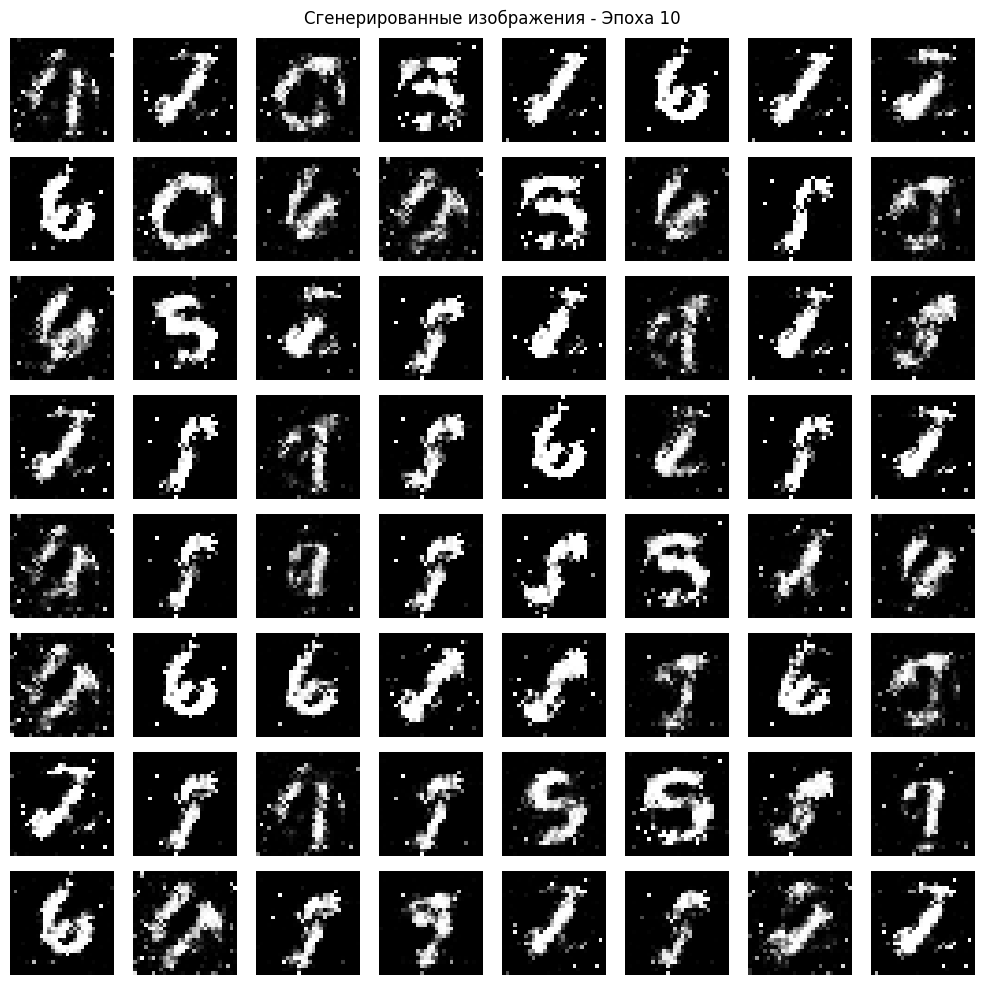

Эпоха 11/50: 100%|█| 938/938 [00:11<00:00, 83.4


Эпоха [11/50] - D_loss: 0.3468, G_loss: 0.6990


Эпоха 12/50: 100%|█| 938/938 [00:11<00:00, 83.7


Эпоха [12/50] - D_loss: 0.3468, G_loss: 0.6988


Эпоха 13/50: 100%|█| 938/938 [00:11<00:00, 82.5


Эпоха [13/50] - D_loss: 0.3470, G_loss: 0.6970


Эпоха 14/50:  26%|▎| 246/938 [00:02<00:08, 83.8


KeyboardInterrupt: 

In [29]:
# Запускаем обучение
G_losses, D_losses = train_gan()

# Построение графиков потерь
plot_losses(G_losses, D_losses)

# Сохраняение финальных изображений
print("Финальные сгенерированные изображения:")
save_generated_images(generator, NUM_EPOCHS)

# Сохраняем финальные модели
torch.save(generator.state_dict(), 'models/generator_final.pth')
torch.save(discriminator.state_dict(), 'models/discriminator_final.pth')
print("Модели сохранены!")


In [ ]:
# Экспериментирование с различными архитектурами

# Версия 2: Улучшенный генератор с Dropout
class ImprovedGenerator(nn.Module):
    def __init__(self, latent_dim=100, img_shape=(1, 28, 28)):
        super(ImprovedGenerator, self).__init__()
        self.img_shape = img_shape
        
        def block(in_feat, out_feat, normalize=True, dropout=False):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if dropout:
                layers.append(nn.Dropout(0.3))
            return layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 256, normalize=False),
            *block(256, 512, dropout=True),
            *block(512, 1024, dropout=True),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Версия 2: Улучшенный дискриминатор с Dropout
class ImprovedDiscriminator(nn.Module):
    def __init__(self, img_shape=(1, 28, 28)):
        super(ImprovedDiscriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.6),  # увеличиваем с 0.4 до 0.6
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.6),  # увеличиваем с 0.4 до 0.6
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

print("Улучшенные архитектуры определены!")
print("Можете поэкспериментировать с разными архитектурами, заменив исходные модели.")


Сравнение моделей:


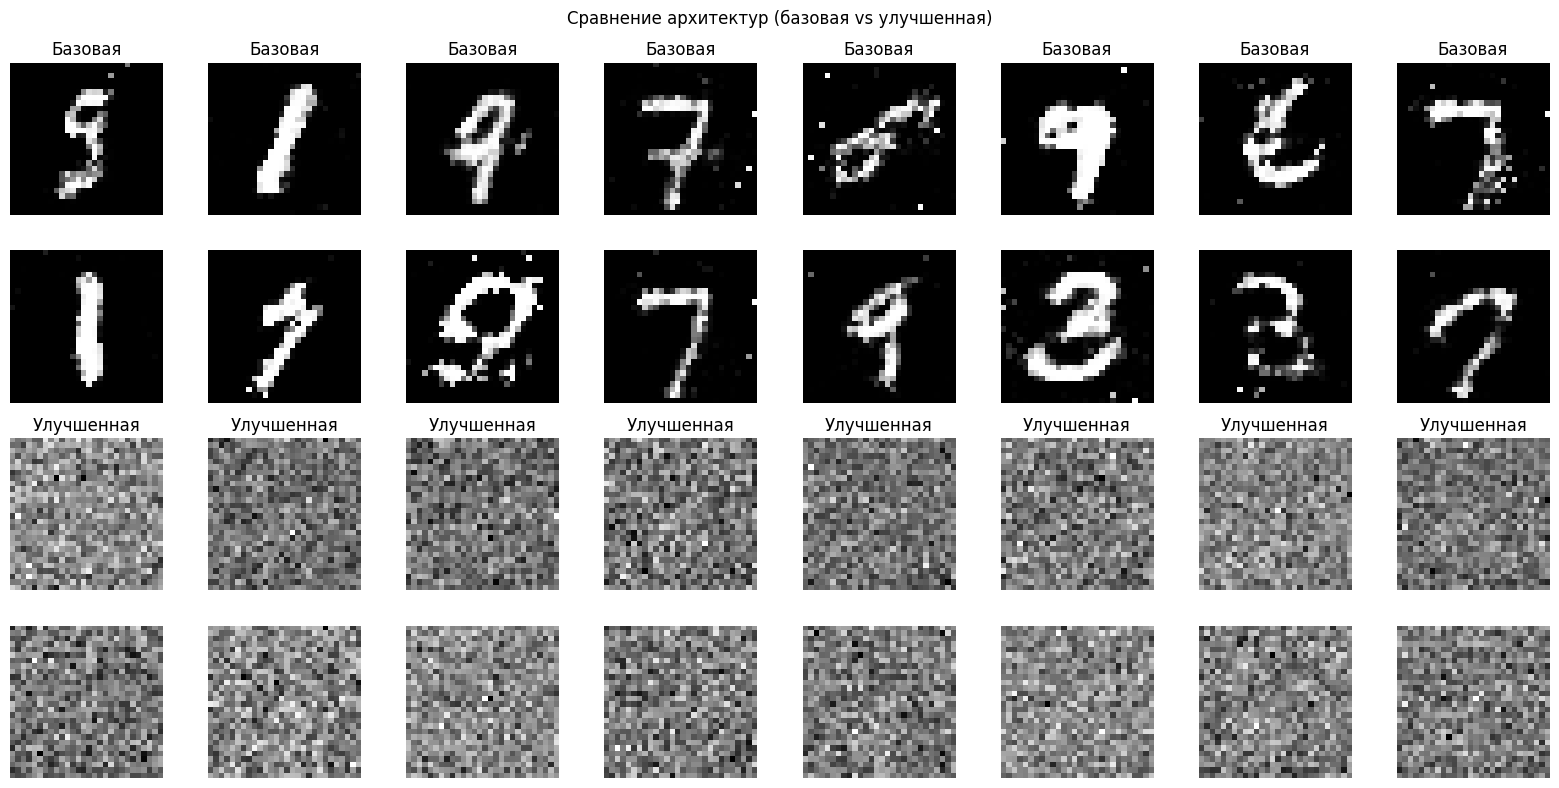


Анализ гиперпараметров:
Рекомендации по гиперпараметрам:
1. Learning Rate: 0.0002 - хороший баланс между скоростью и стабильностью
2. Latent Dimension: 100 - достаточно для MNIST, больше для сложных данных
3. Batch Size: 128 - компромисс между памятью и качеством градиентов
4. Beta1 (Adam): 0.5 - меньше стандартного 0.9 для лучшей стабильности GAN


In [11]:
# Функция для сравнения моделей
def compare_models():
    """Сравнение производительности разных архитектур"""
    
    # Создаем тестовый шум
    test_noise = torch.randn(16, LATENT_DIM).to(device)
    
    # Генерируем изображения базовой моделью
    with torch.no_grad():
        basic_imgs = generator(test_noise).cpu()
    
    # Создаем улучшенную модель (для демонстрации)
    improved_gen = ImprovedGenerator(LATENT_DIM, (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)).to(device)
    
    # Генерируем изображения улучшенной моделью (случайные веса)
    with torch.no_grad():
        improved_imgs = improved_gen(test_noise).cpu()
    
    # Визуализация сравнения
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    
    for i in range(16):
        # Базовая модель (верхние два ряда)
        axes[0 if i < 8 else 1, i % 8].imshow(basic_imgs[i].squeeze(), cmap='gray')
        axes[0 if i < 8 else 1, i % 8].set_title('Базовая' if i < 8 else '')
        axes[0 if i < 8 else 1, i % 8].axis('off')
        
        # Улучшенная модель (нижние два ряда)
        axes[2 if i < 8 else 3, i % 8].imshow(improved_imgs[i].squeeze(), cmap='gray')
        axes[2 if i < 8 else 3, i % 8].set_title('Улучшенная' if i < 8 else '')
        axes[2 if i < 8 else 3, i % 8].axis('off')
    
    plt.suptitle('Сравнение архитектур (базовая vs улучшенная)')
    plt.tight_layout()
    plt.show()

# Функция для анализа гиперпараметров
def hyperparameter_analysis():
    """Анализ влияния различных гиперпараметров"""
    
    hyperparams = {
        'learning_rates': [0.0001, 0.0002, 0.0005],
        'latent_dims': [50, 100, 200],
        'batch_sizes': [64, 128, 256]
    }
    
    print("Рекомендации по гиперпараметрам:")
    print("1. Learning Rate: 0.0002 - хороший баланс между скоростью и стабильностью")
    print("2. Latent Dimension: 100 - достаточно для MNIST, больше для сложных данных")
    print("3. Batch Size: 128 - компромисс между памятью и качеством градиентов")
    print("4. Beta1 (Adam): 0.5 - меньше стандартного 0.9 для лучшей стабильности GAN")
    
    return hyperparams

# Выполняем сравнение
print("Сравнение моделей:")
compare_models()

print("\nАнализ гиперпараметров:")
params = hyperparameter_analysis()
